<a href="https://colab.research.google.com/github/aakhterov/articles/blob/master/A%20Neural%20Probabilistic%20Language%20Model/A_Neural_Probabilistic_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO

Add comments

In [22]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk import FreqDist
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, TextVectorization, Input, Flatten
from tensorflow.keras.activations import softmax
from sklearn.model_selection import train_test_split

In [2]:
# Mount a Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [114]:
n_before = 2
m = 20
h = 30
words_freq_thr = 2
filler_for_rare_words = 'RARE_WORD'

In [3]:
paragraphs = []
path_to_file = "/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt"
with open(path_to_file, mode='r') as file:
  for line in file:
    if line[:-1].strip() != '':
      paragraphs.append(line[:-1])

In [4]:
paragraphs[:5]

['Isaac Asimov',
 'I, Robot',
 'Introduction',
 "I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.",
 "Susan Calvin had been born in the year 1982, they said, which made her seventy-five now. Everyone knew that. Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history. Well, everyone knew that, too."]

In [85]:
sentences = []
for par in paragraphs:
  sentences += [s.strip() for s in re.split(r'\.|!|\?', par) if s.strip()]

In [86]:
sentences[:10]

['Isaac Asimov',
 'I, Robot',
 'Introduction',
 "I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM",
 "I'd spent three days at U",
 'S',
 'Robots and might as well have spent them at home with the Encyclopedia Tellurica',
 'Susan Calvin had been born in the year 1982, they said, which made her seventy-five now',
 'Everyone knew that',
 'Appropriately enough, U']

In [57]:
# sentences = ["I like dog", "i love Coffee, and 4 milk", "i hate milk"]

In [115]:
data = []
all_words = []
for sent in sentences:
  words = re.sub(r'[^a-z0-9\s]', ' ', sent.lower()).split()
  all_words += words
  for i in range(0, len(words)-n_before):
    data.append(' '.join(words[i:i+n_before+1]))

In [116]:
data[:5]

['i looked at', 'looked at my', 'at my notes', 'my notes and', 'notes and i']

In [117]:
len(data)

58981

In [118]:
freq = FreqDist(all_words)

In [119]:
vocabulary = [pair[0] for pair in freq.most_common() if pair[1] > 3]

In [120]:
len(vocabulary), len(freq)

(1937, 7363)

In [121]:
for idx, collacation in enumerate(data):
  new = []
  for word in collacation.split():
    if word in vocabulary:
      new.append(word)
    else:
      new.append(filler_for_rare_words)
  data[idx] = ' '.join(new)

In [122]:
text_vectorization = TextVectorization()
text_vectorization.adapt(data, batch_size=64)
sentences_indices = text_vectorization(data)
sentences_indices.shape

TensorShape([58981, 3])

In [123]:
vocabulary = text_vectorization.get_vocabulary()

In [124]:
vocabulary[:10]

['', '[UNK]', 'rareword', 'the', 'and', 'of', 'a', 'to', 'you', 'in']

In [137]:
X, y = sentences_indices[:, :2].numpy(), sentences_indices[:, 2].numpy()

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [139]:
def NPLM(input_shape, vocabulary, embedding_dim, h):
  inputs = Input(input_shape)
  x = Embedding(input_dim=len(vocabulary), output_dim=embedding_dim)(inputs)
  x = Flatten()(x)
  out1 = Dense(units=h, use_bias=True)(x)
  out1 = tf.math.tanh(out1)
  out1 = Dense(units=len(vocabulary), use_bias=False)(out1)
  out2 = Dense(units=len(vocabulary), use_bias=True)(x)
  y = out1 + out2
  prob = softmax(y)
  model = Model(inputs=inputs, outputs=prob)
  return model

In [140]:
model = NPLM(input_shape=((n_before)), vocabulary=vocabulary, embedding_dim=m, h=h)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 2, 20)        38780       ['input_11[0][0]']               
                                                                                                  
 flatten_10 (Flatten)           (None, 40)           0           ['embedding_10[0][0]']           
                                                                                                  
 dense_30 (Dense)               (None, 30)           1230        ['flatten_10[0][0]']             
                                                                                           

In [141]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/10
1475/1475 [==============================] - 16s 11ms/step - loss: 5.9060 - sparse_categorical_accuracy: 0.1229 - val_loss: 5.5601 - val_sparse_categorical_accuracy: 0.1300
Epoch 2/10
1475/1475 [==============================] - 14s 9ms/step - loss: 5.3832 - sparse_categorical_accuracy: 0.1472 - val_loss: 5.3220 - val_sparse_categorical_accuracy: 0.1501
Epoch 3/10
1475/1475 [==============================] - 16s 11ms/step - loss: 5.2150 - sparse_categorical_accuracy: 0.1625 - val_loss: 5.2489 - val_sparse_categorical_accuracy: 0.1558
Epoch 4/10
1475/1475 [==============================] - 20s 14ms/step - loss: 5.1471 - sparse_categorical_accuracy: 0.1682 - val_loss: 5.2087 - val_sparse_categorical_accuracy: 0.1590
Epoch 5/10
1475/1475 [==============================] - 17s 11ms/step - loss: 5.1009 - sparse_categorical_accuracy: 0.1722 - val_loss: 5.1873 - val_sparse_categorical_accuracy: 0.1605
Epoch 6/10
1475/1475 [==============================] - 14s 10ms/step - loss: 5.0

<Axes: >

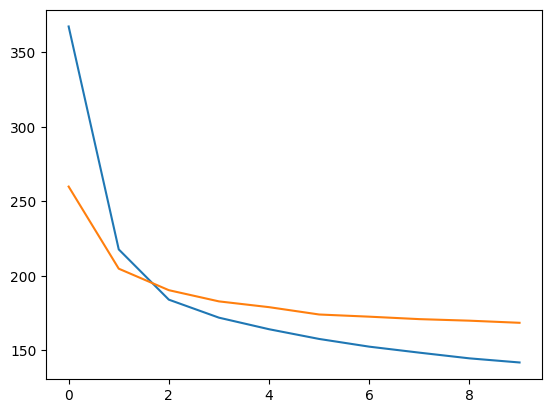

In [142]:
_, ax = plt.subplots(1, 1)
sns.lineplot(data=np.exp(history.history['loss']), ax=ax)
sns.lineplot(data=np.exp(history.history['val_loss']), ax=ax)